In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from itertools import product
import sklearn
# import lightgbm as lgb
# from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import tensorflow as tf
import keras

#Read files:
train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_categories = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Using TensorFlow backend.


In [2]:
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
train.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
items.head()


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [47]:
shops.head()


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
item_categories.head()


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
test.head()


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# EDA


In [9]:
#Check for null values
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

hence we observe that there is no missing value in the training set


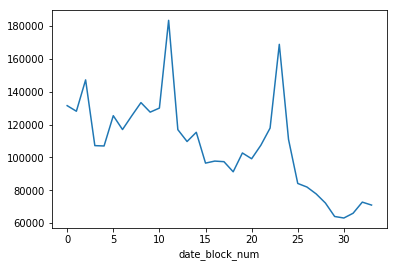

In [9]:
sale_by_month = train.groupby('date_block_num')['item_cnt_day'].sum()
sale_by_month.plot()

we observed that there is a decrease each year with peaks in november


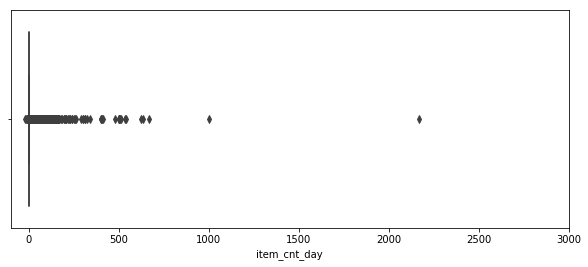

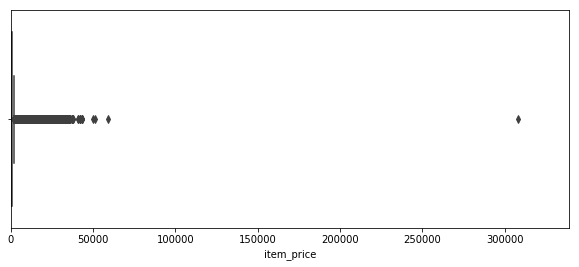

In [10]:
#removing outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)



In [3]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]



In [12]:
x=train[train['item_price']<0]

In [13]:
x

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


then we find the blocks where item price is negative and observe that for shop_id=32 and item id=2973 and date_block_num=4 item price is neagtive and hence we replace it with median of other prices for thr same conditions

In [4]:
median = train[(train.shop_id == 32) & (train.item_id == 2973) & (train.date_block_num == 4) & (
            train.item_price > 0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

In [5]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [6]:
test_block = train['date_block_num'].max() + 1
test['date_block_num'] = test_block
test = test.drop(columns=['ID'])
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


# Feature engineering

In [10]:

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for i in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == i, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == i, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [i]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = pd.concat([grid, test])

In [18]:
grid.head(10)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
5,59,2565,0
6,59,2572,0
7,59,2573,0
8,59,2574,0
9,59,2593,0


In [11]:
import gc
# Groupby data to get shop-item-month aggregates
gb = train.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [21]:
all_data.head(10)

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0
5,59,2565,0,0.0,2017.0,2.0
6,59,2572,0,0.0,2017.0,12.0
7,59,2573,0,0.0,2017.0,16.0
8,59,2574,0,2.0,2017.0,119.0
9,59,2593,0,0.0,2017.0,5.0


In [12]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift

In [21]:
all_data.head()


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

gc.collect()

28

In [23]:
all_data.head()



,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [14]:
dates = all_data['date_block_num']

dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

X_train = all_data[all_data.date_block_num < 34].drop(to_drop_cols, axis=1)
X_test = all_data[all_data.date_block_num == 34].drop(to_drop_cols, axis=1)


Y_train = all_data.loc[dates <  34, 'target'].values
Y_valid =  all_data.loc[dates == 33, 'target'].values



In [25]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [34]:
Y_train


array([ 4.,  3., 14., ...,  0.,  0.,  0.], dtype=float32)

In [15]:
target_range = [0, 20]


# Modelling 

Neural Networks

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2, l1
from keras.optimizers import RMSprop, Adam


In [18]:

# define model
def Sales_prediction_model(input_shape):
    in_layer = Input(input_shape)
    x = Dense(16,kernel_initializer='RandomUniform', kernel_regularizer=l2(0.02), activation = "relu")(in_layer)
    x = Dense(8, kernel_initializer='RandomUniform', kernel_regularizer=l2(0.02), activation = "relu")(x)
    x = Dense(1, kernel_initializer='RandomUniform', kernel_regularizer=l2(0.02), activation = "relu")(x)
    
    model = Model(inputs = in_layer, outputs = x, name='Sales_prediction_model')
    return model

# NN cannot take missing values, fill NaN with 0.
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

# We do no feature scaling here. 
# Some features like 'item_avg_sale_last_6' are already scaled in feature engineering part.

input_shape = [X_train.shape[1]]
model = Sales_prediction_model(input_shape)
model.compile(optimizer = Adam(lr=0.0005) , loss = ["mse"], metrics=['mse'])
model.fit(X_train, Y_train, batch_size = 10000, epochs=5)

Epoch 1/5


4710000/6425094 [====================>.........] - ETA: 15:32 - loss: 23.7435 - mse: 23.73 - ETA: 8:12 - loss: 14.2651 - mse: 14.2570 - ETA: 4:18 - loss: 13.9395 - mse: 13.931 - ETA: 2:58 - loss: 11.5537 - mse: 11.545 - ETA: 2:18 - loss: 10.3773 - mse: 10.369 - ETA: 1:54 - loss: 8.7321 - mse: 8.7243  - ETA: 1:37 - loss: 8.2694 - mse: 8.261 - ETA: 1:25 - loss: 7.5032 - mse: 7.495 - ETA: 1:13 - loss: 9.0606 - mse: 9.053 - ETA: 1:03 - loss: 11.4077 - mse: 11.400 - ETA: 59s - loss: 11.8327 - mse: 11.825 - ETA: 55s - loss: 11.2268 - mse: 11.21 - ETA: 51s - loss: 10.1966 - mse: 10.18 - ETA: 47s - loss: 9.5861 - mse: 9.5787 - ETA: 45s - loss: 9.1429 - mse: 9.13 - ETA: 43s - loss: 9.1745 - mse: 9.16 - ETA: 42s - loss: 8.8510 - mse: 8.84 - ETA: 40s - loss: 8.4773 - mse: 8.47 - ETA: 39s - loss: 8.2248 - mse: 8.21 - ETA: 38s - loss: 8.0449 - mse: 8.03 - ETA: 36s - loss: 7.8523 - mse: 7.84 - ETA: 35s - loss: 8.5634 - mse: 8.55 - ETA: 34s - loss: 10.0627 - mse: 10.05 - ETA: 33s - loss: 9.7968 - mse

5100000/6425094 [======================>.......] - ETA: 6:17 - loss: 3.5565 - mse: 3.520 - ETA: 1:45 - loss: 2.9028 - mse: 2.866 - ETA: 1:15 - loss: 2.9029 - mse: 2.866 - ETA: 1:01 - loss: 5.0628 - mse: 5.026 - ETA: 52s - loss: 12.7329 - mse: 12.69 - ETA: 44s - loss: 11.0015 - mse: 10.96 - ETA: 38s - loss: 9.8713 - mse: 9.8346 - ETA: 35s - loss: 17.9785 - mse: 17.94 - ETA: 34s - loss: 16.5489 - mse: 16.51 - ETA: 32s - loss: 15.3625 - mse: 15.32 - ETA: 30s - loss: 14.7614 - mse: 14.72 - ETA: 29s - loss: 13.8341 - mse: 13.79 - ETA: 28s - loss: 12.7165 - mse: 12.67 - ETA: 27s - loss: 12.1889 - mse: 12.15 - ETA: 26s - loss: 11.9034 - mse: 11.86 - ETA: 25s - loss: 11.4154 - mse: 11.37 - ETA: 24s - loss: 10.7043 - mse: 10.66 - ETA: 24s - loss: 10.2819 - mse: 10.24 - ETA: 23s - loss: 9.9639 - mse: 9.9260 - ETA: 23s - loss: 9.6718 - mse: 9.63 - ETA: 22s - loss: 9.9820 - mse: 9.94 - ETA: 22s - loss: 9.6876 - mse: 9.64 - ETA: 22s - loss: 9.5042 - mse: 9.46 - ETA: 21s - loss: 9.2314 - mse: 9.19 -

6425094/6425094 [==============================] - ETA: 3s - loss: 7.0209 - mse: 6.968 - ETA: 3s - loss: 7.1341 - mse: 7.081 - ETA: 3s - loss: 7.1341 - mse: 7.081 - ETA: 3s - loss: 7.1315 - mse: 7.078 - ETA: 3s - loss: 7.1234 - mse: 7.070 - ETA: 3s - loss: 7.1436 - mse: 7.090 - ETA: 3s - loss: 7.1304 - mse: 7.077 - ETA: 3s - loss: 7.1585 - mse: 7.105 - ETA: 3s - loss: 7.1514 - mse: 7.098 - ETA: 2s - loss: 7.1320 - mse: 7.079 - ETA: 2s - loss: 7.1180 - mse: 7.065 - ETA: 2s - loss: 7.0986 - mse: 7.045 - ETA: 2s - loss: 7.0733 - mse: 7.020 - ETA: 2s - loss: 7.2838 - mse: 7.230 - ETA: 2s - loss: 7.4111 - mse: 7.357 - ETA: 2s - loss: 7.3848 - mse: 7.331 - ETA: 2s - loss: 7.3679 - mse: 7.314 - ETA: 2s - loss: 7.3618 - mse: 7.308 - ETA: 2s - loss: 7.5587 - mse: 7.505 - ETA: 2s - loss: 7.5510 - mse: 7.497 - ETA: 2s - loss: 7.5325 - mse: 7.478 - ETA: 2s - loss: 7.9958 - mse: 7.942 - ETA: 2s - loss: 7.9762 - mse: 7.922 - ETA: 2s - loss: 7.9500 - mse: 7.896 - ETA: 2s - loss: 7.9907 - mse: 7.936 -

5150000/6425094 [=======================>......] - ETA: 5:54 - loss: 2.1407 - mse: 2.068 - ETA: 2:09 - loss: 3.8838 - mse: 3.811 - ETA: 1:12 - loss: 3.4859 - mse: 3.414 - ETA: 58s - loss: 3.1431 - mse: 3.071 - ETA: 47s - loss: 4.1435 - mse: 4.07 - ETA: 40s - loss: 3.7855 - mse: 3.71 - ETA: 36s - loss: 4.4138 - mse: 4.34 - ETA: 33s - loss: 4.2744 - mse: 4.20 - ETA: 32s - loss: 4.2407 - mse: 4.16 - ETA: 31s - loss: 4.2239 - mse: 4.15 - ETA: 29s - loss: 6.0310 - mse: 5.95 - ETA: 29s - loss: 5.7395 - mse: 5.66 - ETA: 28s - loss: 5.7414 - mse: 5.66 - ETA: 27s - loss: 5.5231 - mse: 5.45 - ETA: 26s - loss: 5.7231 - mse: 5.65 - ETA: 26s - loss: 5.5472 - mse: 5.47 - ETA: 25s - loss: 5.4159 - mse: 5.34 - ETA: 24s - loss: 5.1864 - mse: 5.11 - ETA: 24s - loss: 5.0276 - mse: 4.95 - ETA: 23s - loss: 4.8738 - mse: 4.80 - ETA: 23s - loss: 5.1291 - mse: 5.05 - ETA: 23s - loss: 5.1744 - mse: 5.10 - ETA: 22s - loss: 5.1329 - mse: 5.06 - ETA: 22s - loss: 5.2854 - mse: 5.21 - ETA: 22s - loss: 5.2261 - mse:

5120000/6425094 [======================>.......] - ETA: 7:23 - loss: 8.6768 - mse: 8.583 - ETA: 2:40 - loss: 4.4743 - mse: 4.381 - ETA: 1:44 - loss: 3.5742 - mse: 3.481 - ETA: 1:11 - loss: 3.3702 - mse: 3.277 - ETA: 1:00 - loss: 3.7653 - mse: 3.672 - ETA: 53s - loss: 3.6466 - mse: 3.553 - ETA: 47s - loss: 3.5119 - mse: 3.41 - ETA: 41s - loss: 5.3100 - mse: 5.21 - ETA: 39s - loss: 5.0430 - mse: 4.94 - ETA: 37s - loss: 5.9907 - mse: 5.89 - ETA: 34s - loss: 5.7745 - mse: 5.68 - ETA: 32s - loss: 5.5225 - mse: 5.42 - ETA: 30s - loss: 5.1872 - mse: 5.09 - ETA: 29s - loss: 5.2205 - mse: 5.12 - ETA: 29s - loss: 5.1405 - mse: 5.04 - ETA: 28s - loss: 5.0813 - mse: 4.98 - ETA: 27s - loss: 4.9113 - mse: 4.81 - ETA: 26s - loss: 4.7578 - mse: 4.66 - ETA: 25s - loss: 5.8621 - mse: 5.76 - ETA: 25s - loss: 5.8760 - mse: 5.78 - ETA: 24s - loss: 5.9333 - mse: 5.83 - ETA: 23s - loss: 5.7859 - mse: 5.69 - ETA: 23s - loss: 5.6468 - mse: 5.55 - ETA: 23s - loss: 6.1320 - mse: 6.03 - ETA: 22s - loss: 6.1367 - 

6425094/6425094 [==============================] - ETA: 3s - loss: 6.9693 - mse: 6.871 - ETA: 3s - loss: 6.9734 - mse: 6.875 - ETA: 3s - loss: 6.9561 - mse: 6.858 - ETA: 3s - loss: 6.9616 - mse: 6.863 - ETA: 3s - loss: 7.0306 - mse: 6.932 - ETA: 3s - loss: 7.0136 - mse: 6.915 - ETA: 3s - loss: 7.0367 - mse: 6.938 - ETA: 3s - loss: 7.5341 - mse: 7.435 - ETA: 3s - loss: 7.5160 - mse: 7.417 - ETA: 3s - loss: 7.5479 - mse: 7.449 - ETA: 2s - loss: 7.5317 - mse: 7.433 - ETA: 2s - loss: 7.5844 - mse: 7.486 - ETA: 2s - loss: 7.6170 - mse: 7.518 - ETA: 2s - loss: 7.5925 - mse: 7.494 - ETA: 2s - loss: 7.5804 - mse: 7.482 - ETA: 2s - loss: 7.5532 - mse: 7.454 - ETA: 2s - loss: 7.5342 - mse: 7.435 - ETA: 2s - loss: 7.5144 - mse: 7.416 - ETA: 2s - loss: 7.4900 - mse: 7.391 - ETA: 2s - loss: 7.4683 - mse: 7.369 - ETA: 2s - loss: 7.4554 - mse: 7.357 - ETA: 2s - loss: 7.4425 - mse: 7.344 - ETA: 2s - loss: 7.4266 - mse: 7.328 - ETA: 2s - loss: 7.4074 - mse: 7.308 - ETA: 2s - loss: 7.3893 - mse: 7.290 -

5070000/6425094 [======================>.......] - ETA: 6:03 - loss: 1.4449 - mse: 1.340 - ETA: 2:12 - loss: 4.1044 - mse: 3.999 - ETA: 1:26 - loss: 3.7305 - mse: 3.626 - ETA: 1:00 - loss: 3.2418 - mse: 3.137 - ETA: 51s - loss: 5.3654 - mse: 5.261 - ETA: 45s - loss: 5.7119 - mse: 5.60 - ETA: 41s - loss: 5.4854 - mse: 5.38 - ETA: 38s - loss: 5.4562 - mse: 5.35 - ETA: 35s - loss: 5.2278 - mse: 5.12 - ETA: 33s - loss: 6.1485 - mse: 6.04 - ETA: 31s - loss: 5.8441 - mse: 5.73 - ETA: 29s - loss: 5.6662 - mse: 5.56 - ETA: 28s - loss: 6.3561 - mse: 6.25 - ETA: 27s - loss: 6.6555 - mse: 6.55 - ETA: 26s - loss: 6.4560 - mse: 6.35 - ETA: 25s - loss: 6.2834 - mse: 6.17 - ETA: 25s - loss: 6.0965 - mse: 5.99 - ETA: 24s - loss: 7.0090 - mse: 6.90 - ETA: 23s - loss: 9.4887 - mse: 9.38 - ETA: 23s - loss: 10.9718 - mse: 10.86 - ETA: 22s - loss: 10.6116 - mse: 10.50 - ETA: 22s - loss: 10.3050 - mse: 10.20 - ETA: 22s - loss: 10.0399 - mse: 9.9356 - ETA: 21s - loss: 9.8274 - mse: 9.723 - ETA: 21s - loss: 9

In [35]:
pred_nn = model.predict(X_test).clip(0, 20)[:,0]

submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_nn})
submission.to_csv('pred_nn.csv', index=False)

LightGBM

In [20]:
import lightgbm as lgb
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=Y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)

In [31]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission.to_csv('pred_lgb.csv', index=False)

In [36]:
X_test_level2 = np.c_[pred_nn, pred_lgb]
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
Y_train_level2 = Y_train[dates_train.isin(dates_train_level2)]

In [38]:
X_train_level2 = np.zeros([Y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur =  all_data.loc[dates == cur_block_num, 'target'].values
    
    input_shape = [X_train_cur.shape[1]]
    model = Sales_prediction_model(input_shape)
    model.compile(optimizer = Adam(lr=0.0005) , loss = ["mse"], metrics=['mse'])
    model.fit(X_train_cur, y_train_cur, batch_size = 10000, epochs=5)
    pred_nn = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_nn.clip(*target_range)[:,0]
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb.clip(*target_range)

27
Epoch 1/5


4750000/4810730 [============================>.] - ETA: 7:51 - loss: 5.4917 - mse: 5.484 - ETA: 2:45 - loss: 25.7807 - mse: 25.773 - ETA: 1:28 - loss: 15.9187 - mse: 15.911 - ETA: 1:08 - loss: 12.5703 - mse: 12.563 - ETA: 57s - loss: 11.3045 - mse: 11.297 - ETA: 46s - loss: 9.4147 - mse: 9.4076 - ETA: 39s - loss: 9.4584 - mse: 9.45 - ETA: 36s - loss: 8.8766 - mse: 8.86 - ETA: 34s - loss: 11.6300 - mse: 11.62 - ETA: 31s - loss: 11.6566 - mse: 11.64 - ETA: 29s - loss: 11.3154 - mse: 11.30 - ETA: 28s - loss: 16.7180 - mse: 16.71 - ETA: 26s - loss: 15.8027 - mse: 15.79 - ETA: 26s - loss: 15.1118 - mse: 15.10 - ETA: 25s - loss: 14.3080 - mse: 14.30 - ETA: 24s - loss: 13.8407 - mse: 13.83 - ETA: 23s - loss: 13.2919 - mse: 13.28 - ETA: 23s - loss: 12.7965 - mse: 12.78 - ETA: 22s - loss: 12.9405 - mse: 12.93 - ETA: 21s - loss: 12.7770 - mse: 12.77 - ETA: 21s - loss: 13.1332 - mse: 13.12 - ETA: 20s - loss: 12.7604 - mse: 12.75 - ETA: 20s - loss: 12.6255 - mse: 12.61 - ETA: 19s - loss: 12.6935 -

4670000/4810730 [============================>.] - ETA: 3:23 - loss: 17.3302 - mse: 17.308 - ETA: 59s - loss: 8.7110 - mse: 8.6896  - ETA: 43s - loss: 7.8818 - mse: 7.86 - ETA: 35s - loss: 6.9664 - mse: 6.94 - ETA: 31s - loss: 6.0463 - mse: 6.02 - ETA: 26s - loss: 7.3293 - mse: 7.30 - ETA: 24s - loss: 9.0926 - mse: 9.07 - ETA: 23s - loss: 8.2235 - mse: 8.20 - ETA: 22s - loss: 10.0953 - mse: 10.07 - ETA: 21s - loss: 9.4438 - mse: 9.4218 - ETA: 20s - loss: 8.8229 - mse: 8.80 - ETA: 19s - loss: 8.5776 - mse: 8.55 - ETA: 19s - loss: 8.5910 - mse: 8.56 - ETA: 18s - loss: 8.4717 - mse: 8.44 - ETA: 17s - loss: 8.3675 - mse: 8.34 - ETA: 17s - loss: 8.1086 - mse: 8.08 - ETA: 17s - loss: 7.8128 - mse: 7.79 - ETA: 16s - loss: 7.4037 - mse: 7.38 - ETA: 16s - loss: 7.2438 - mse: 7.22 - ETA: 15s - loss: 7.0403 - mse: 7.01 - ETA: 15s - loss: 6.8262 - mse: 6.80 - ETA: 15s - loss: 6.6447 - mse: 6.62 - ETA: 15s - loss: 8.2754 - mse: 8.25 - ETA: 15s - loss: 8.0979 - mse: 8.07 - ETA: 14s - loss: 8.1875 - 

4810730/4810730 [==============================] - ETA: 0s - loss: 6.7062 - mse: 6.670 - ETA: 0s - loss: 6.6922 - mse: 6.656 - ETA: 0s - loss: 6.6786 - mse: 6.642 - ETA: 0s - loss: 6.6528 - mse: 6.616 - ETA: 0s - loss: 6.6350 - mse: 6.598 - ETA: 0s - loss: 6.6281 - mse: 6.592 - 13s 3us/step - loss: 6.7993 - mse: 6.7632
Epoch 3/5
4810730/4810730 [==============================] - ETA: 3:52 - loss: 6.3295 - mse: 6.278 - ETA: 1:25 - loss: 3.4078 - mse: 3.356 - ETA: 55s - loss: 3.1872 - mse: 3.136 - ETA: 43s - loss: 3.5603 - mse: 3.50 - ETA: 36s - loss: 3.8684 - mse: 3.81 - ETA: 32s - loss: 4.3369 - mse: 4.28 - ETA: 27s - loss: 4.4388 - mse: 4.38 - ETA: 25s - loss: 4.8259 - mse: 4.77 - ETA: 23s - loss: 4.8708 - mse: 4.81 - ETA: 21s - loss: 6.5472 - mse: 6.49 - ETA: 21s - loss: 6.4157 - mse: 6.36 - ETA: 20s - loss: 6.0544 - mse: 6.00 - ETA: 19s - loss: 5.9511 - mse: 5.89 - ETA: 18s - loss: 5.7177 - mse: 5.66 - ETA: 18s - loss: 6.0915 - mse: 6.03 - ETA: 17s - loss: 5.9254 - mse: 5.87 - ETA: 

4810730/4810730 [==============================] - ETA: 3:26 - loss: 11.9319 - mse: 11.862 - ETA: 1:17 - loss: 7.6466 - mse: 7.5773  - ETA: 51s - loss: 17.9911 - mse: 17.92 - ETA: 40s - loss: 13.4553 - mse: 13.38 - ETA: 34s - loss: 11.1272 - mse: 11.05 - ETA: 30s - loss: 9.5312 - mse: 9.4616 - ETA: 26s - loss: 8.6105 - mse: 8.54 - ETA: 23s - loss: 8.1652 - mse: 8.09 - ETA: 22s - loss: 8.3434 - mse: 8.27 - ETA: 21s - loss: 7.8343 - mse: 7.76 - ETA: 20s - loss: 7.4317 - mse: 7.36 - ETA: 19s - loss: 7.7013 - mse: 7.63 - ETA: 18s - loss: 7.3496 - mse: 7.27 - ETA: 17s - loss: 6.9164 - mse: 6.84 - ETA: 17s - loss: 7.1184 - mse: 7.04 - ETA: 16s - loss: 6.8489 - mse: 6.77 - ETA: 16s - loss: 6.6551 - mse: 6.58 - ETA: 16s - loss: 6.5010 - mse: 6.43 - ETA: 16s - loss: 6.3720 - mse: 6.30 - ETA: 15s - loss: 6.2071 - mse: 6.13 - ETA: 15s - loss: 6.2869 - mse: 6.21 - ETA: 15s - loss: 6.1990 - mse: 6.12 - ETA: 14s - loss: 7.0365 - mse: 6.96 - ETA: 14s - loss: 6.8603 - mse: 6.78 - ETA: 14s - loss: 6.72

4690000/5068102 [==========================>...] - ETA: 11:40 - loss: 15.9871 - mse: 15.97 - ETA: 4:04 - loss: 8.3366 - mse: 8.3286   - ETA: 2:31 - loss: 7.7969 - mse: 7.789 - ETA: 1:51 - loss: 6.6315 - mse: 6.623 - ETA: 1:29 - loss: 5.7045 - mse: 5.696 - ETA: 1:15 - loss: 5.7419 - mse: 5.734 - ETA: 1:05 - loss: 6.1083 - mse: 6.100 - ETA: 58s - loss: 6.7597 - mse: 6.752 - ETA: 50s - loss: 6.3730 - mse: 6.36 - ETA: 46s - loss: 6.7193 - mse: 6.71 - ETA: 43s - loss: 6.3514 - mse: 6.34 - ETA: 40s - loss: 6.0819 - mse: 6.07 - ETA: 38s - loss: 6.1615 - mse: 6.15 - ETA: 36s - loss: 5.9169 - mse: 5.90 - ETA: 34s - loss: 6.4450 - mse: 6.43 - ETA: 33s - loss: 6.8429 - mse: 6.83 - ETA: 31s - loss: 7.4873 - mse: 7.47 - ETA: 29s - loss: 8.0054 - mse: 7.99 - ETA: 28s - loss: 7.6900 - mse: 7.68 - ETA: 28s - loss: 7.6124 - mse: 7.60 - ETA: 27s - loss: 8.0308 - mse: 8.02 - ETA: 26s - loss: 7.8120 - mse: 7.80 - ETA: 25s - loss: 8.1898 - mse: 8.18 - ETA: 25s - loss: 8.1267 - mse: 8.11 - ETA: 24s - loss: 

5068102/5068102 [==============================] - ETA: 1s - loss: 8.5886 - mse: 8.575 - ETA: 1s - loss: 8.6012 - mse: 8.587 - ETA: 0s - loss: 8.6563 - mse: 8.642 - ETA: 0s - loss: 8.6436 - mse: 8.629 - ETA: 0s - loss: 8.6980 - mse: 8.684 - ETA: 0s - loss: 8.6876 - mse: 8.673 - ETA: 0s - loss: 8.7751 - mse: 8.761 - ETA: 0s - loss: 8.8034 - mse: 8.789 - ETA: 0s - loss: 8.8904 - mse: 8.876 - ETA: 0s - loss: 8.8666 - mse: 8.852 - ETA: 0s - loss: 8.8505 - mse: 8.836 - ETA: 0s - loss: 8.8577 - mse: 8.843 - ETA: 0s - loss: 8.8568 - mse: 8.842 - ETA: 0s - loss: 8.8237 - mse: 8.809 - ETA: 0s - loss: 8.8055 - mse: 8.791 - ETA: 0s - loss: 8.7676 - mse: 8.753 - ETA: 0s - loss: 8.8062 - mse: 8.791 - 15s 3us/step - loss: 8.8236 - mse: 8.8092
Epoch 2/5


4750000/5068102 [===========================>..] - ETA: 4:46 - loss: 3.0896 - mse: 3.064 - ETA: 1:18 - loss: 4.3134 - mse: 4.287 - ETA: 56s - loss: 6.9573 - mse: 6.931 - ETA: 41s - loss: 5.6835 - mse: 5.65 - ETA: 33s - loss: 5.5543 - mse: 5.52 - ETA: 30s - loss: 5.2594 - mse: 5.23 - ETA: 28s - loss: 5.1347 - mse: 5.10 - ETA: 27s - loss: 4.9543 - mse: 4.92 - ETA: 24s - loss: 4.6059 - mse: 4.57 - ETA: 23s - loss: 4.6888 - mse: 4.66 - ETA: 22s - loss: 4.4995 - mse: 4.47 - ETA: 20s - loss: 4.3517 - mse: 4.32 - ETA: 20s - loss: 4.2361 - mse: 4.20 - ETA: 19s - loss: 4.1361 - mse: 4.10 - ETA: 19s - loss: 4.4042 - mse: 4.37 - ETA: 18s - loss: 4.8158 - mse: 4.78 - ETA: 18s - loss: 5.8587 - mse: 5.83 - ETA: 17s - loss: 8.4171 - mse: 8.39 - ETA: 17s - loss: 8.1951 - mse: 8.16 - ETA: 17s - loss: 8.0077 - mse: 7.98 - ETA: 17s - loss: 8.1577 - mse: 8.13 - ETA: 16s - loss: 8.4286 - mse: 8.40 - ETA: 16s - loss: 8.3566 - mse: 8.32 - ETA: 16s - loss: 8.1672 - mse: 8.13 - ETA: 16s - loss: 8.0550 - mse: 8

4640000/5068102 [==========================>...] - ETA: 3:44 - loss: 2.9627 - mse: 2.910 - ETA: 1:05 - loss: 4.8364 - mse: 4.783 - ETA: 42s - loss: 4.2921 - mse: 4.239 - ETA: 35s - loss: 4.5362 - mse: 4.48 - ETA: 31s - loss: 4.8323 - mse: 4.77 - ETA: 28s - loss: 4.9000 - mse: 4.84 - ETA: 26s - loss: 4.6598 - mse: 4.60 - ETA: 25s - loss: 4.9538 - mse: 4.90 - ETA: 24s - loss: 5.2862 - mse: 5.23 - ETA: 23s - loss: 5.0092 - mse: 4.95 - ETA: 22s - loss: 4.8469 - mse: 4.79 - ETA: 21s - loss: 4.8375 - mse: 4.78 - ETA: 20s - loss: 4.6447 - mse: 4.59 - ETA: 20s - loss: 4.5598 - mse: 4.50 - ETA: 19s - loss: 4.5019 - mse: 4.44 - ETA: 19s - loss: 4.5263 - mse: 4.47 - ETA: 18s - loss: 5.0556 - mse: 5.00 - ETA: 18s - loss: 4.9647 - mse: 4.91 - ETA: 18s - loss: 4.9328 - mse: 4.87 - ETA: 17s - loss: 4.8985 - mse: 4.84 - ETA: 17s - loss: 5.4867 - mse: 5.43 - ETA: 17s - loss: 5.3540 - mse: 5.30 - ETA: 17s - loss: 5.2698 - mse: 5.21 - ETA: 16s - loss: 5.1665 - mse: 5.11 - ETA: 16s - loss: 5.9794 - mse: 5

5068102/5068102 [==============================] - ETA: 1s - loss: 6.7103 - mse: 6.647 - ETA: 1s - loss: 6.6964 - mse: 6.633 - ETA: 1s - loss: 6.6817 - mse: 6.618 - ETA: 1s - loss: 6.6711 - mse: 6.607 - ETA: 0s - loss: 6.6520 - mse: 6.588 - ETA: 0s - loss: 6.7072 - mse: 6.643 - ETA: 0s - loss: 6.7016 - mse: 6.638 - ETA: 0s - loss: 6.7214 - mse: 6.658 - ETA: 0s - loss: 6.7017 - mse: 6.638 - ETA: 0s - loss: 6.7049 - mse: 6.641 - ETA: 0s - loss: 6.6922 - mse: 6.628 - ETA: 0s - loss: 6.6771 - mse: 6.613 - ETA: 0s - loss: 6.6519 - mse: 6.588 - ETA: 0s - loss: 7.0431 - mse: 6.979 - ETA: 0s - loss: 7.0268 - mse: 6.963 - ETA: 0s - loss: 7.0696 - mse: 7.006 - ETA: 0s - loss: 7.0464 - mse: 6.982 - ETA: 0s - loss: 7.0321 - mse: 6.968 - 15s 3us/step - loss: 7.0087 - mse: 6.9450
Epoch 4/5


4730000/5068102 [==========================>...] - ETA: 3:45 - loss: 2.4651 - mse: 2.395 - ETA: 1:23 - loss: 3.7004 - mse: 3.631 - ETA: 54s - loss: 3.4442 - mse: 3.374 - ETA: 43s - loss: 3.3917 - mse: 3.32 - ETA: 36s - loss: 3.3111 - mse: 3.24 - ETA: 32s - loss: 3.5718 - mse: 3.50 - ETA: 29s - loss: 3.5338 - mse: 3.46 - ETA: 27s - loss: 4.3796 - mse: 4.31 - ETA: 25s - loss: 5.3868 - mse: 5.31 - ETA: 23s - loss: 4.9088 - mse: 4.83 - ETA: 21s - loss: 8.2756 - mse: 8.20 - ETA: 21s - loss: 7.8424 - mse: 7.77 - ETA: 20s - loss: 7.4370 - mse: 7.36 - ETA: 19s - loss: 8.3260 - mse: 8.25 - ETA: 19s - loss: 8.0981 - mse: 8.02 - ETA: 19s - loss: 7.8471 - mse: 7.77 - ETA: 18s - loss: 7.5735 - mse: 7.50 - ETA: 17s - loss: 7.7412 - mse: 7.67 - ETA: 17s - loss: 7.4476 - mse: 7.37 - ETA: 17s - loss: 7.2320 - mse: 7.16 - ETA: 16s - loss: 6.9896 - mse: 6.92 - ETA: 16s - loss: 6.8699 - mse: 6.80 - ETA: 16s - loss: 6.7478 - mse: 6.67 - ETA: 15s - loss: 6.5442 - mse: 6.47 - ETA: 15s - loss: 6.3745 - mse: 6

4420000/5068102 [=========================>....] - ETA: 3:54 - loss: 3.8620 - mse: 3.777 - ETA: 1:26 - loss: 3.0184 - mse: 2.934 - ETA: 56s - loss: 3.1433 - mse: 3.059 - ETA: 44s - loss: 3.2435 - mse: 3.15 - ETA: 37s - loss: 11.8471 - mse: 11.76 - ETA: 33s - loss: 10.6523 - mse: 10.56 - ETA: 30s - loss: 9.6426 - mse: 9.5584 - ETA: 28s - loss: 8.7091 - mse: 8.62 - ETA: 26s - loss: 8.0223 - mse: 7.93 - ETA: 24s - loss: 10.8758 - mse: 10.79 - ETA: 23s - loss: 10.5202 - mse: 10.43 - ETA: 22s - loss: 11.0217 - mse: 10.93 - ETA: 21s - loss: 10.4233 - mse: 10.33 - ETA: 21s - loss: 10.6906 - mse: 10.60 - ETA: 20s - loss: 10.1520 - mse: 10.06 - ETA: 19s - loss: 9.8238 - mse: 9.7394 - ETA: 19s - loss: 9.7922 - mse: 9.70 - ETA: 19s - loss: 9.4540 - mse: 9.36 - ETA: 18s - loss: 9.1852 - mse: 9.10 - ETA: 18s - loss: 8.8976 - mse: 8.81 - ETA: 17s - loss: 9.9146 - mse: 9.83 - ETA: 17s - loss: 9.4591 - mse: 9.37 - ETA: 17s - loss: 9.1670 - mse: 9.08 - ETA: 16s - loss: 8.8908 - mse: 8.80 - ETA: 16s - l

5068102/5068102 [==============================] - ETA: 1s - loss: 6.8694 - mse: 6.782 - ETA: 1s - loss: 6.8553 - mse: 6.768 - ETA: 1s - loss: 6.8364 - mse: 6.749 - ETA: 1s - loss: 6.8316 - mse: 6.745 - ETA: 1s - loss: 6.8082 - mse: 6.721 - ETA: 1s - loss: 6.7929 - mse: 6.706 - ETA: 1s - loss: 6.8127 - mse: 6.726 - ETA: 1s - loss: 6.8015 - mse: 6.714 - ETA: 1s - loss: 6.7888 - mse: 6.702 - ETA: 1s - loss: 6.7740 - mse: 6.687 - ETA: 1s - loss: 6.7703 - mse: 6.683 - ETA: 1s - loss: 6.7588 - mse: 6.671 - ETA: 1s - loss: 6.7496 - mse: 6.662 - ETA: 1s - loss: 6.7628 - mse: 6.675 - ETA: 1s - loss: 6.7392 - mse: 6.652 - ETA: 0s - loss: 6.7931 - mse: 6.706 - ETA: 0s - loss: 6.7809 - mse: 6.693 - ETA: 0s - loss: 6.7657 - mse: 6.678 - ETA: 0s - loss: 6.7678 - mse: 6.680 - ETA: 0s - loss: 6.7489 - mse: 6.661 - ETA: 0s - loss: 6.7386 - mse: 6.651 - ETA: 0s - loss: 6.7222 - mse: 6.635 - ETA: 0s - loss: 6.7042 - mse: 6.617 - ETA: 0s - loss: 6.7360 - mse: 6.648 - ETA: 0s - loss: 6.7542 - mse: 6.667 -

4950000/5300554 [===========================>..] - ETA: 8:59 - loss: 13.5640 - mse: 13.556 - ETA: 3:09 - loss: 8.0831 - mse: 8.0753  - ETA: 1:58 - loss: 6.4511 - mse: 6.443 - ETA: 1:28 - loss: 6.6790 - mse: 6.671 - ETA: 1:11 - loss: 13.6538 - mse: 13.646 - ETA: 1:01 - loss: 11.8018 - mse: 11.794 - ETA: 50s - loss: 10.1020 - mse: 10.094 - ETA: 45s - loss: 9.2480 - mse: 9.2406 - ETA: 42s - loss: 8.8154 - mse: 8.80 - ETA: 39s - loss: 14.5954 - mse: 14.58 - ETA: 37s - loss: 13.8656 - mse: 13.85 - ETA: 35s - loss: 13.0197 - mse: 13.01 - ETA: 33s - loss: 12.4533 - mse: 12.44 - ETA: 31s - loss: 11.9446 - mse: 11.93 - ETA: 29s - loss: 13.3844 - mse: 13.37 - ETA: 28s - loss: 14.9649 - mse: 14.95 - ETA: 28s - loss: 15.1051 - mse: 15.09 - ETA: 27s - loss: 15.4129 - mse: 15.40 - ETA: 26s - loss: 14.7928 - mse: 14.78 - ETA: 25s - loss: 15.1394 - mse: 15.13 - ETA: 24s - loss: 15.1301 - mse: 15.12 - ETA: 23s - loss: 15.6134 - mse: 15.60 - ETA: 22s - loss: 15.0075 - mse: 15.00 - ETA: 22s - loss: 14.76

5180000/5300554 [============================>.] - ETA: 4:19 - loss: 3.9419 - mse: 3.913 - ETA: 1:35 - loss: 2.5481 - mse: 2.519 - ETA: 1:02 - loss: 5.1907 - mse: 5.162 - ETA: 48s - loss: 5.1705 - mse: 5.142 - ETA: 40s - loss: 4.5864 - mse: 4.55 - ETA: 36s - loss: 4.2979 - mse: 4.26 - ETA: 31s - loss: 7.2491 - mse: 7.22 - ETA: 28s - loss: 16.3600 - mse: 16.33 - ETA: 26s - loss: 17.6196 - mse: 17.59 - ETA: 24s - loss: 15.4561 - mse: 15.42 - ETA: 23s - loss: 17.1187 - mse: 17.08 - ETA: 22s - loss: 16.6253 - mse: 16.59 - ETA: 21s - loss: 15.6753 - mse: 15.64 - ETA: 20s - loss: 14.7434 - mse: 14.71 - ETA: 19s - loss: 14.4641 - mse: 14.43 - ETA: 19s - loss: 13.9571 - mse: 13.92 - ETA: 18s - loss: 13.2357 - mse: 13.20 - ETA: 18s - loss: 14.0973 - mse: 14.06 - ETA: 17s - loss: 13.3240 - mse: 13.29 - ETA: 17s - loss: 12.9275 - mse: 12.89 - ETA: 17s - loss: 12.4705 - mse: 12.44 - ETA: 17s - loss: 12.0659 - mse: 12.03 - ETA: 16s - loss: 11.5023 - mse: 11.47 - ETA: 16s - loss: 11.3715 - mse: 11.3

5300554/5300554 [==============================] - ETA: 0s - loss: 7.5966 - mse: 7.550 - ETA: 0s - loss: 7.5712 - mse: 7.524 - ETA: 0s - loss: 7.5514 - mse: 7.504 - ETA: 0s - loss: 7.5647 - mse: 7.518 - ETA: 0s - loss: 7.5506 - mse: 7.503 - 14s 3us/step - loss: 7.5499 - mse: 7.5033
Epoch 3/5
5300554/5300554 [==============================] - ETA: 4:06 - loss: 4.6933 - mse: 4.630 - ETA: 1:32 - loss: 3.6423 - mse: 3.579 - ETA: 52s - loss: 5.4359 - mse: 5.373 - ETA: 39s - loss: 4.6980 - mse: 4.63 - ETA: 32s - loss: 4.9812 - mse: 4.91 - ETA: 28s - loss: 5.4568 - mse: 5.39 - ETA: 25s - loss: 5.8084 - mse: 5.74 - ETA: 23s - loss: 5.4774 - mse: 5.41 - ETA: 22s - loss: 5.2689 - mse: 5.20 - ETA: 21s - loss: 5.5521 - mse: 5.48 - ETA: 20s - loss: 5.3833 - mse: 5.32 - ETA: 20s - loss: 5.1609 - mse: 5.09 - ETA: 19s - loss: 5.1469 - mse: 5.08 - ETA: 18s - loss: 5.2432 - mse: 5.18 - ETA: 18s - loss: 6.8191 - mse: 6.75 - ETA: 18s - loss: 6.7954 - mse: 6.73 - ETA: 17s - loss: 7.3876 - mse: 7.32 - ETA: 

Epoch 4/5


5210000/5300554 [============================>.] - ETA: 3:59 - loss: 4.9056 - mse: 4.816 - ETA: 1:29 - loss: 4.6468 - mse: 4.557 - ETA: 51s - loss: 5.3542 - mse: 5.264 - ETA: 38s - loss: 4.9213 - mse: 4.83 - ETA: 34s - loss: 4.6392 - mse: 4.54 - ETA: 31s - loss: 4.4085 - mse: 4.31 - ETA: 28s - loss: 4.0991 - mse: 4.00 - ETA: 25s - loss: 3.9300 - mse: 3.84 - ETA: 24s - loss: 3.8531 - mse: 3.76 - ETA: 22s - loss: 3.7445 - mse: 3.65 - ETA: 22s - loss: 3.9010 - mse: 3.81 - ETA: 21s - loss: 4.1276 - mse: 4.03 - ETA: 20s - loss: 4.0150 - mse: 3.92 - ETA: 19s - loss: 3.9950 - mse: 3.90 - ETA: 19s - loss: 4.1632 - mse: 4.07 - ETA: 18s - loss: 4.0994 - mse: 4.00 - ETA: 18s - loss: 4.6013 - mse: 4.51 - ETA: 17s - loss: 5.2476 - mse: 5.15 - ETA: 17s - loss: 5.2295 - mse: 5.13 - ETA: 17s - loss: 5.2255 - mse: 5.13 - ETA: 17s - loss: 5.1782 - mse: 5.08 - ETA: 16s - loss: 5.1178 - mse: 5.02 - ETA: 16s - loss: 4.9963 - mse: 4.90 - ETA: 16s - loss: 5.1228 - mse: 5.03 - ETA: 15s - loss: 5.0839 - mse: 4

5180000/5300554 [============================>.] - ETA: 4:05 - loss: 1.8822 - mse: 1.780 - ETA: 1:32 - loss: 2.2156 - mse: 2.113 - ETA: 1:00 - loss: 2.3685 - mse: 2.266 - ETA: 42s - loss: 2.9439 - mse: 2.841 - ETA: 34s - loss: 3.0123 - mse: 2.90 - ETA: 31s - loss: 4.4144 - mse: 4.31 - ETA: 28s - loss: 4.1152 - mse: 4.01 - ETA: 26s - loss: 4.0191 - mse: 3.91 - ETA: 24s - loss: 3.8451 - mse: 3.74 - ETA: 23s - loss: 3.7567 - mse: 3.65 - ETA: 22s - loss: 3.7929 - mse: 3.69 - ETA: 21s - loss: 4.0088 - mse: 3.90 - ETA: 20s - loss: 4.3164 - mse: 4.21 - ETA: 19s - loss: 5.1157 - mse: 5.01 - ETA: 19s - loss: 4.9282 - mse: 4.82 - ETA: 19s - loss: 4.7830 - mse: 4.68 - ETA: 18s - loss: 4.6188 - mse: 4.51 - ETA: 18s - loss: 4.6982 - mse: 4.59 - ETA: 17s - loss: 4.7149 - mse: 4.61 - ETA: 17s - loss: 5.1705 - mse: 5.06 - ETA: 17s - loss: 5.7409 - mse: 5.63 - ETA: 16s - loss: 5.7565 - mse: 5.65 - ETA: 16s - loss: 5.8931 - mse: 5.79 - ETA: 16s - loss: 5.8633 - mse: 5.76 - ETA: 15s - loss: 6.1342 - mse:

5300554/5300554 [==============================] - ETA: 0s - loss: 6.4742 - mse: 6.367 - ETA: 0s - loss: 6.4668 - mse: 6.360 - ETA: 0s - loss: 6.4505 - mse: 6.343 - ETA: 0s - loss: 6.4638 - mse: 6.357 - ETA: 0s - loss: 6.4524 - mse: 6.345 - 14s 3us/step - loss: 6.4518 - mse: 6.3450
30
Epoch 1/5
5524842/5524842 [==============================] - ETA: 6:16 - loss: 30.7666 - mse: 30.758 - ETA: 2:14 - loss: 13.3441 - mse: 13.336 - ETA: 1:12 - loss: 22.6413 - mse: 22.633 - ETA: 51s - loss: 27.2352 - mse: 27.227 - ETA: 41s - loss: 21.8867 - mse: 21.87 - ETA: 34s - loss: 19.2224 - mse: 19.21 - ETA: 30s - loss: 16.5356 - mse: 16.52 - ETA: 27s - loss: 14.6244 - mse: 14.61 - ETA: 25s - loss: 13.8338 - mse: 13.82 - ETA: 23s - loss: 12.7678 - mse: 12.76 - ETA: 21s - loss: 11.8329 - mse: 11.82 - ETA: 20s - loss: 11.3081 - mse: 11.30 - ETA: 19s - loss: 10.8135 - mse: 10.80 - ETA: 18s - loss: 10.2748 - mse: 10.26 - ETA: 17s - loss: 11.2236 - mse: 11.21 - ETA: 17s - loss: 10.6680 - mse: 10.66 - ETA: 1

5524842/5524842 [==============================] - ETA: 3:34 - loss: 1.3601 - mse: 1.300 - ETA: 1:02 - loss: 4.0993 - mse: 4.040 - ETA: 40s - loss: 4.1200 - mse: 4.060 - ETA: 31s - loss: 5.0059 - mse: 4.94 - ETA: 26s - loss: 4.8953 - mse: 4.83 - ETA: 23s - loss: 9.2705 - mse: 9.21 - ETA: 21s - loss: 8.7602 - mse: 8.70 - ETA: 20s - loss: 8.8290 - mse: 8.76 - ETA: 19s - loss: 8.3697 - mse: 8.31 - ETA: 18s - loss: 8.0088 - mse: 7.94 - ETA: 17s - loss: 7.4818 - mse: 7.42 - ETA: 16s - loss: 8.3082 - mse: 8.24 - ETA: 16s - loss: 7.8485 - mse: 7.78 - ETA: 16s - loss: 7.6976 - mse: 7.63 - ETA: 15s - loss: 7.4050 - mse: 7.34 - ETA: 15s - loss: 7.0674 - mse: 7.00 - ETA: 15s - loss: 6.9306 - mse: 6.87 - ETA: 14s - loss: 6.7317 - mse: 6.67 - ETA: 14s - loss: 6.6286 - mse: 6.56 - ETA: 14s - loss: 6.4498 - mse: 6.39 - ETA: 14s - loss: 6.3010 - mse: 6.24 - ETA: 13s - loss: 6.1551 - mse: 6.09 - ETA: 13s - loss: 6.3141 - mse: 6.25 - ETA: 13s - loss: 6.1828 - mse: 6.12 - ETA: 13s - loss: 6.1012 - mse: 6

5524842/5524842 [==============================] - ETA: 4:20 - loss: 7.6002 - mse: 7.505 - ETA: 1:14 - loss: 3.5273 - mse: 3.432 - ETA: 47s - loss: 2.8289 - mse: 2.734 - ETA: 36s - loss: 2.7375 - mse: 2.64 - ETA: 30s - loss: 4.7772 - mse: 4.68 - ETA: 27s - loss: 4.6052 - mse: 4.51 - ETA: 24s - loss: 4.2619 - mse: 4.16 - ETA: 22s - loss: 4.0246 - mse: 3.92 - ETA: 21s - loss: 11.0501 - mse: 10.95 - ETA: 20s - loss: 10.3442 - mse: 10.24 - ETA: 19s - loss: 9.5763 - mse: 9.4815 - ETA: 18s - loss: 9.1479 - mse: 9.05 - ETA: 17s - loss: 8.7605 - mse: 8.66 - ETA: 17s - loss: 8.3429 - mse: 8.24 - ETA: 16s - loss: 8.0333 - mse: 7.93 - ETA: 16s - loss: 7.7033 - mse: 7.60 - ETA: 16s - loss: 7.4605 - mse: 7.36 - ETA: 16s - loss: 8.0547 - mse: 7.95 - ETA: 15s - loss: 7.8642 - mse: 7.76 - ETA: 15s - loss: 7.6526 - mse: 7.55 - ETA: 15s - loss: 7.5098 - mse: 7.41 - ETA: 15s - loss: 7.2519 - mse: 7.15 - ETA: 15s - loss: 7.2969 - mse: 7.20 - ETA: 15s - loss: 7.1438 - mse: 7.04 - ETA: 14s - loss: 7.2822 - 

5753731/5753731 [==============================] - ETA: 3:28 - loss: 14.2010 - mse: 14.172 - ETA: 59s - loss: 7.9134 - mse: 7.8845  - ETA: 38s - loss: 6.8232 - mse: 6.79 - ETA: 30s - loss: 5.4779 - mse: 5.44 - ETA: 25s - loss: 4.8735 - mse: 4.84 - ETA: 22s - loss: 5.2478 - mse: 5.21 - ETA: 20s - loss: 4.8232 - mse: 4.79 - ETA: 19s - loss: 5.2816 - mse: 5.25 - ETA: 18s - loss: 5.0147 - mse: 4.98 - ETA: 17s - loss: 5.2270 - mse: 5.19 - ETA: 16s - loss: 4.9592 - mse: 4.92 - ETA: 15s - loss: 4.9767 - mse: 4.94 - ETA: 15s - loss: 4.8071 - mse: 4.77 - ETA: 14s - loss: 5.3790 - mse: 5.34 - ETA: 14s - loss: 5.2550 - mse: 5.22 - ETA: 13s - loss: 5.0871 - mse: 5.05 - ETA: 13s - loss: 4.9247 - mse: 4.89 - ETA: 13s - loss: 4.7431 - mse: 4.71 - ETA: 13s - loss: 6.1627 - mse: 6.13 - ETA: 12s - loss: 6.4967 - mse: 6.46 - ETA: 12s - loss: 6.3316 - mse: 6.30 - ETA: 12s - loss: 6.1577 - mse: 6.12 - ETA: 12s - loss: 6.1321 - mse: 6.10 - ETA: 12s - loss: 6.0058 - mse: 5.97 - ETA: 11s - loss: 5.9181 - mse:

5753731/5753731 [==============================] - ETA: 3:22 - loss: 1.4638 - mse: 1.383 - ETA: 59s - loss: 2.9120 - mse: 2.832 - ETA: 37s - loss: 3.0931 - mse: 3.01 - ETA: 29s - loss: 4.6567 - mse: 4.57 - ETA: 25s - loss: 4.3173 - mse: 4.23 - ETA: 22s - loss: 4.6446 - mse: 4.56 - ETA: 20s - loss: 4.4445 - mse: 4.36 - ETA: 18s - loss: 4.0597 - mse: 3.97 - ETA: 17s - loss: 3.7681 - mse: 3.68 - ETA: 17s - loss: 4.4012 - mse: 4.31 - ETA: 16s - loss: 4.4002 - mse: 4.31 - ETA: 15s - loss: 4.6447 - mse: 4.56 - ETA: 15s - loss: 7.9069 - mse: 7.82 - ETA: 14s - loss: 7.5643 - mse: 7.48 - ETA: 14s - loss: 7.3940 - mse: 7.31 - ETA: 14s - loss: 7.1314 - mse: 7.04 - ETA: 13s - loss: 6.8609 - mse: 6.77 - ETA: 13s - loss: 6.6006 - mse: 6.51 - ETA: 13s - loss: 7.5861 - mse: 7.50 - ETA: 12s - loss: 7.3614 - mse: 7.27 - ETA: 12s - loss: 7.1696 - mse: 7.08 - ETA: 12s - loss: 7.5592 - mse: 7.47 - ETA: 12s - loss: 7.2913 - mse: 7.20 - ETA: 12s - loss: 7.5968 - mse: 7.51 - ETA: 11s - loss: 7.4085 - mse: 7.3

5968267/5968267 [==============================] - ETA: 6:33 - loss: 7.2386 - mse: 7.230 - ETA: 1:47 - loss: 5.5785 - mse: 5.570 - ETA: 1:05 - loss: 17.7777 - mse: 17.770 - ETA: 49s - loss: 17.6924 - mse: 17.684 - ETA: 40s - loss: 17.0367 - mse: 17.02 - ETA: 34s - loss: 15.6247 - mse: 15.61 - ETA: 30s - loss: 14.0325 - mse: 14.02 - ETA: 29s - loss: 13.0611 - mse: 13.05 - ETA: 26s - loss: 12.0168 - mse: 12.00 - ETA: 25s - loss: 11.0309 - mse: 11.02 - ETA: 23s - loss: 10.7187 - mse: 10.71 - ETA: 22s - loss: 10.2988 - mse: 10.29 - ETA: 21s - loss: 9.7470 - mse: 9.7397 - ETA: 20s - loss: 9.6944 - mse: 9.68 - ETA: 19s - loss: 11.7076 - mse: 11.70 - ETA: 18s - loss: 11.1916 - mse: 11.18 - ETA: 18s - loss: 10.9496 - mse: 10.94 - ETA: 17s - loss: 14.1637 - mse: 14.15 - ETA: 17s - loss: 14.0553 - mse: 14.04 - ETA: 16s - loss: 14.0689 - mse: 14.06 - ETA: 16s - loss: 13.8784 - mse: 13.87 - ETA: 16s - loss: 13.4887 - mse: 13.48 - ETA: 16s - loss: 13.9236 - mse: 13.91 - ETA: 16s - loss: 13.3554 - m

5968267/5968267 [==============================] - ETA: 3:45 - loss: 2.2595 - mse: 2.188 - ETA: 1:05 - loss: 4.8795 - mse: 4.808 - ETA: 41s - loss: 4.4486 - mse: 4.377 - ETA: 32s - loss: 4.1843 - mse: 4.11 - ETA: 27s - loss: 5.1461 - mse: 5.07 - ETA: 24s - loss: 4.9162 - mse: 4.84 - ETA: 21s - loss: 4.7007 - mse: 4.62 - ETA: 20s - loss: 6.9651 - mse: 6.89 - ETA: 19s - loss: 6.4488 - mse: 6.37 - ETA: 18s - loss: 6.1059 - mse: 6.03 - ETA: 17s - loss: 5.9980 - mse: 5.92 - ETA: 16s - loss: 6.0290 - mse: 5.95 - ETA: 15s - loss: 5.7507 - mse: 5.67 - ETA: 15s - loss: 5.7286 - mse: 5.65 - ETA: 15s - loss: 5.5802 - mse: 5.50 - ETA: 14s - loss: 5.6112 - mse: 5.53 - ETA: 14s - loss: 5.4241 - mse: 5.35 - ETA: 14s - loss: 5.2701 - mse: 5.19 - ETA: 13s - loss: 5.1033 - mse: 5.02 - ETA: 13s - loss: 5.0391 - mse: 4.96 - ETA: 13s - loss: 4.9737 - mse: 4.90 - ETA: 13s - loss: 4.8554 - mse: 4.78 - ETA: 12s - loss: 4.7382 - mse: 4.66 - ETA: 12s - loss: 4.6721 - mse: 4.59 - ETA: 12s - loss: 4.7340 - mse: 4

5968267/5968267 [==============================] - ETA: 4:32 - loss: 2.3755 - mse: 2.262 - ETA: 1:16 - loss: 6.8266 - mse: 6.713 - ETA: 48s - loss: 14.1550 - mse: 14.04 - ETA: 37s - loss: 10.9234 - mse: 10.81 - ETA: 31s - loss: 9.2085 - mse: 9.0954 - ETA: 27s - loss: 7.8183 - mse: 7.70 - ETA: 24s - loss: 7.1050 - mse: 6.99 - ETA: 22s - loss: 6.6193 - mse: 6.50 - ETA: 21s - loss: 6.7671 - mse: 6.65 - ETA: 20s - loss: 6.5012 - mse: 6.38 - ETA: 19s - loss: 6.6812 - mse: 6.56 - ETA: 18s - loss: 6.6441 - mse: 6.53 - ETA: 17s - loss: 6.3269 - mse: 6.21 - ETA: 17s - loss: 6.1940 - mse: 6.08 - ETA: 16s - loss: 5.9394 - mse: 5.82 - ETA: 16s - loss: 6.0852 - mse: 5.97 - ETA: 15s - loss: 6.0808 - mse: 5.96 - ETA: 15s - loss: 5.8662 - mse: 5.75 - ETA: 15s - loss: 5.7186 - mse: 5.60 - ETA: 14s - loss: 5.7444 - mse: 5.63 - ETA: 14s - loss: 6.2042 - mse: 6.09 - ETA: 14s - loss: 6.5811 - mse: 6.46 - ETA: 14s - loss: 6.4450 - mse: 6.33 - ETA: 13s - loss: 6.3287 - mse: 6.21 - ETA: 13s - loss: 6.1965 - m

6130000/6186922 [============================>.] - ETA: 7:00 - loss: 3.9694 - mse: 3.961 - ETA: 1:54 - loss: 24.5086 - mse: 24.501 - ETA: 1:10 - loss: 19.2340 - mse: 19.226 - ETA: 52s - loss: 14.1152 - mse: 14.107 - ETA: 42s - loss: 15.8426 - mse: 15.83 - ETA: 36s - loss: 13.4426 - mse: 13.43 - ETA: 32s - loss: 12.2291 - mse: 12.22 - ETA: 29s - loss: 14.7127 - mse: 14.70 - ETA: 27s - loss: 13.3262 - mse: 13.31 - ETA: 25s - loss: 12.5058 - mse: 12.49 - ETA: 23s - loss: 13.4557 - mse: 13.44 - ETA: 22s - loss: 12.5835 - mse: 12.57 - ETA: 22s - loss: 12.0002 - mse: 11.99 - ETA: 21s - loss: 15.0525 - mse: 15.04 - ETA: 20s - loss: 14.1687 - mse: 14.16 - ETA: 19s - loss: 17.2059 - mse: 17.19 - ETA: 19s - loss: 16.6143 - mse: 16.60 - ETA: 18s - loss: 16.2858 - mse: 16.27 - ETA: 17s - loss: 16.0060 - mse: 16.00 - ETA: 17s - loss: 15.9362 - mse: 15.93 - ETA: 16s - loss: 16.8914 - mse: 16.88 - ETA: 16s - loss: 17.7521 - mse: 17.74 - ETA: 16s - loss: 17.0868 - mse: 17.08 - ETA: 15s - loss: 17.0103

6186922/6186922 [==============================] - ETA: 3:47 - loss: 4.7422 - mse: 4.677 - ETA: 1:04 - loss: 4.6905 - mse: 4.625 - ETA: 41s - loss: 8.0840 - mse: 8.018 - ETA: 32s - loss: 9.1671 - mse: 9.10 - ETA: 27s - loss: 7.7036 - mse: 7.63 - ETA: 24s - loss: 7.0217 - mse: 6.95 - ETA: 22s - loss: 6.8878 - mse: 6.82 - ETA: 20s - loss: 6.2256 - mse: 6.16 - ETA: 19s - loss: 5.7596 - mse: 5.69 - ETA: 18s - loss: 5.5007 - mse: 5.43 - ETA: 17s - loss: 5.6327 - mse: 5.56 - ETA: 16s - loss: 5.3959 - mse: 5.33 - ETA: 16s - loss: 5.1243 - mse: 5.05 - ETA: 15s - loss: 5.5645 - mse: 5.49 - ETA: 15s - loss: 5.3076 - mse: 5.24 - ETA: 14s - loss: 5.4303 - mse: 5.36 - ETA: 14s - loss: 5.3847 - mse: 5.31 - ETA: 14s - loss: 5.3735 - mse: 5.30 - ETA: 13s - loss: 5.1979 - mse: 5.13 - ETA: 13s - loss: 5.0955 - mse: 5.02 - ETA: 13s - loss: 5.0084 - mse: 4.94 - ETA: 13s - loss: 4.8681 - mse: 4.80 - ETA: 13s - loss: 4.7984 - mse: 4.73 - ETA: 12s - loss: 4.7148 - mse: 4.64 - ETA: 12s - loss: 4.6019 - mse: 4

6186922/6186922 [==============================] - ETA: 3:57 - loss: 6.7853 - mse: 6.684 - ETA: 1:08 - loss: 4.9548 - mse: 4.854 - ETA: 43s - loss: 4.4740 - mse: 4.373 - ETA: 33s - loss: 4.7273 - mse: 4.62 - ETA: 28s - loss: 4.1965 - mse: 4.09 - ETA: 25s - loss: 4.4813 - mse: 4.38 - ETA: 23s - loss: 12.7980 - mse: 12.69 - ETA: 21s - loss: 12.0399 - mse: 11.93 - ETA: 20s - loss: 10.9353 - mse: 10.83 - ETA: 18s - loss: 10.0318 - mse: 9.9307 - ETA: 18s - loss: 9.6242 - mse: 9.522 - ETA: 17s - loss: 9.0578 - mse: 8.95 - ETA: 16s - loss: 8.5662 - mse: 8.46 - ETA: 16s - loss: 8.1552 - mse: 8.05 - ETA: 15s - loss: 7.6966 - mse: 7.59 - ETA: 15s - loss: 13.2567 - mse: 13.15 - ETA: 15s - loss: 12.6168 - mse: 12.51 - ETA: 14s - loss: 12.1088 - mse: 12.00 - ETA: 14s - loss: 11.5832 - mse: 11.48 - ETA: 14s - loss: 11.1937 - mse: 11.09 - ETA: 13s - loss: 11.0956 - mse: 10.99 - ETA: 13s - loss: 10.7077 - mse: 10.60 - ETA: 13s - loss: 10.9365 - mse: 10.83 - ETA: 13s - loss: 10.5633 - mse: 10.46 - ETA:

# Ensembling : Simple Averaging

In [54]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = []
for alpha in alphas_to_try:
    mix = alpha*X_train_level2[:,0] + (1-alpha)*X_train_level2[:,1]
    r2_scores.append(r2_score(Y_train_level2, mix))

r2_scores = np.array(r2_scores)

# YOUR CODE GOES HERE
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.067000; Corresponding r2 score on train: 0.097417


In [55]:
pred_simple_averaging = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_simple_averaging})
submission.to_csv('submission_simple_averaging.csv', index=False)